In [1]:
import pyrealsense2 as rs
import cv2
import matplotlib.pyplot as plt
import numpy as np

## Creating Depth and Color Images

In [2]:
width = 1280
height = 720
fps = 30

In [3]:
pipeline = rs.pipeline()
config = rs.config()
config.enable_stream(rs.stream.depth, width, height, rs.format.z16, fps)
config.enable_stream(rs.stream.color, width, height, rs.format.rgb8, fps)

In [92]:
profile = pipeline.start(config)

In [93]:
align_to = rs.stream.color
align = rs.align(align_to)

In [94]:
frames = pipeline.wait_for_frames()

In [95]:
aligned_frames = align.process(frames)

depth_frame = aligned_frames.get_depth_frame()
color_frame = aligned_frames.get_color_frame()

depth_image = np.asanyarray(depth_frame.get_data())
color_image = np.asanyarray(color_frame.get_data())

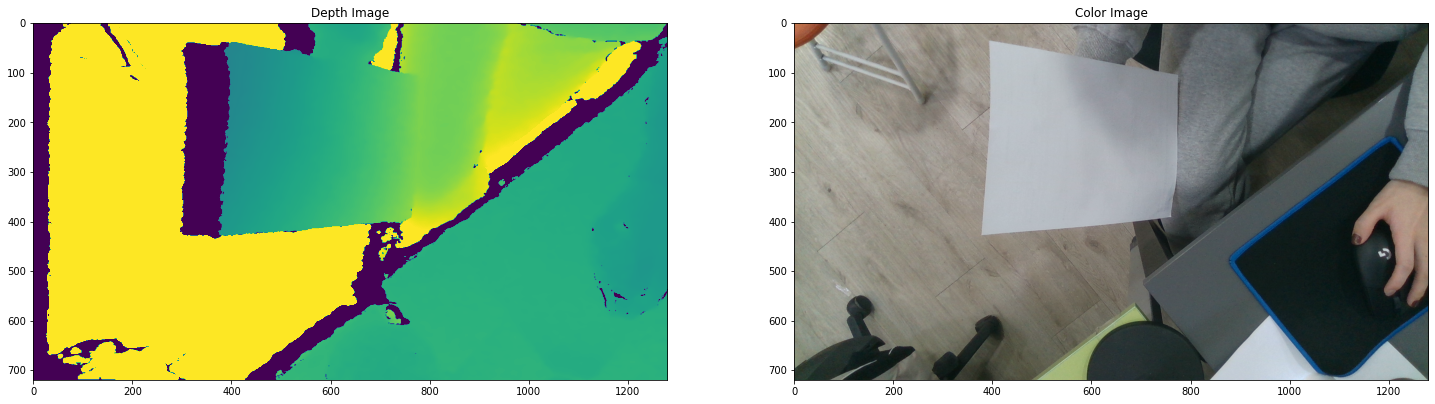

In [96]:
fig = plt.figure(figsize=(25,10))
row = 1
col = 2

ax1 = fig.add_subplot(row,col,1)
ax1.imshow(depth_image, vmin=200, vmax=800)
ax1.set_title("Depth Image")

ax2 = fig.add_subplot(row,col,2)
ax2.imshow(color_image)
ax2.set_title("Color Image")

plt.show()

In [97]:
pipeline.stop()

## Mask and Normal Vector Generation

In [98]:
def generate_mask(event,x,y,flag,data):
    if event == cv2.EVENT_FLAG_LBUTTON:
        cv2.circle(data['im'],(x,y),3,(0,255,0),5,16)
        cv2.imshow("Mask",data["im"])
        if len(data["points"]) < 4:
            data['points'].append([x,y])

def get_normal(event,x,y,flag,data):
    if event == cv2.EVENT_FLAG_LBUTTON:
        cv2.circle(data['im'],(x,y),3,(0,0,255),5,16)
        cv2.imshow("Normal",data["im"])
        if len(data["points"]) < 3:
            data['points'].append([x,y])
    
def get_points(im,type):
    data = {}
    data['im'] = cv2.cvtColor(im.copy(),cv2.COLOR_RGB2BGR)
    data['points'] = []
    
    if type == "mask":
        cv2.imshow("Mask",cv2.cvtColor(im,cv2.COLOR_RGB2BGR))
        cv2.setMouseCallback("Mask",generate_mask,data)
    else:
        cv2.imshow("Normal",cv2.cvtColor(im,cv2.COLOR_RGB2BGR))
        cv2.setMouseCallback("Normal",get_normal,data)
    cv2.waitKey(0)

    points = np.array(data['points'],dtype=float)
    return points


In [99]:
mask_points = get_points(color_image,"mask")

cv2.waitKey(0)
cv2.destroyAllWindows()

QObject::moveToThread: Current thread (0x55e2e21cfe60) is not the object's thread (0x55e2e19d2000).
Cannot move to target thread (0x55e2e21cfe60)

QObject::moveToThread: Current thread (0x55e2e21cfe60) is not the object's thread (0x55e2e19d2000).
Cannot move to target thread (0x55e2e21cfe60)

QObject::moveToThread: Current thread (0x55e2e21cfe60) is not the object's thread (0x55e2e19d2000).
Cannot move to target thread (0x55e2e21cfe60)

QObject::moveToThread: Current thread (0x55e2e21cfe60) is not the object's thread (0x55e2e19d2000).
Cannot move to target thread (0x55e2e21cfe60)

QObject::moveToThread: Current thread (0x55e2e21cfe60) is not the object's thread (0x55e2e19d2000).
Cannot move to target thread (0x55e2e21cfe60)

QObject::moveToThread: Current thread (0x55e2e21cfe60) is not the object's thread (0x55e2e19d2000).
Cannot move to target thread (0x55e2e21cfe60)

QObject::moveToThread: Current thread (0x55e2e21cfe60) is not the object's thread (0x55e2e19d2000).
Cannot move to tar

In [188]:
normal_points = get_points(color_image,"normal")

cv2.waitKey(0)
cv2.destroyAllWindows()

QObject::moveToThread: Current thread (0x55e2e21cfe60) is not the object's thread (0x55e2e19d2000).
Cannot move to target thread (0x55e2e21cfe60)

QObject::moveToThread: Current thread (0x55e2e21cfe60) is not the object's thread (0x55e2e19d2000).
Cannot move to target thread (0x55e2e21cfe60)

QObject::moveToThread: Current thread (0x55e2e21cfe60) is not the object's thread (0x55e2e19d2000).
Cannot move to target thread (0x55e2e21cfe60)

QObject::moveToThread: Current thread (0x55e2e21cfe60) is not the object's thread (0x55e2e19d2000).
Cannot move to target thread (0x55e2e21cfe60)

QObject::moveToThread: Current thread (0x55e2e21cfe60) is not the object's thread (0x55e2e19d2000).
Cannot move to target thread (0x55e2e21cfe60)

QObject::moveToThread: Current thread (0x55e2e21cfe60) is not the object's thread (0x55e2e19d2000).
Cannot move to target thread (0x55e2e21cfe60)

QObject::moveToThread: Current thread (0x55e2e21cfe60) is not the object's thread (0x55e2e19d2000).
Cannot move to tar

In [189]:
mask_points

array([[395.,  36.],
       [379., 429.],
       [760., 390.],
       [774., 107.]])

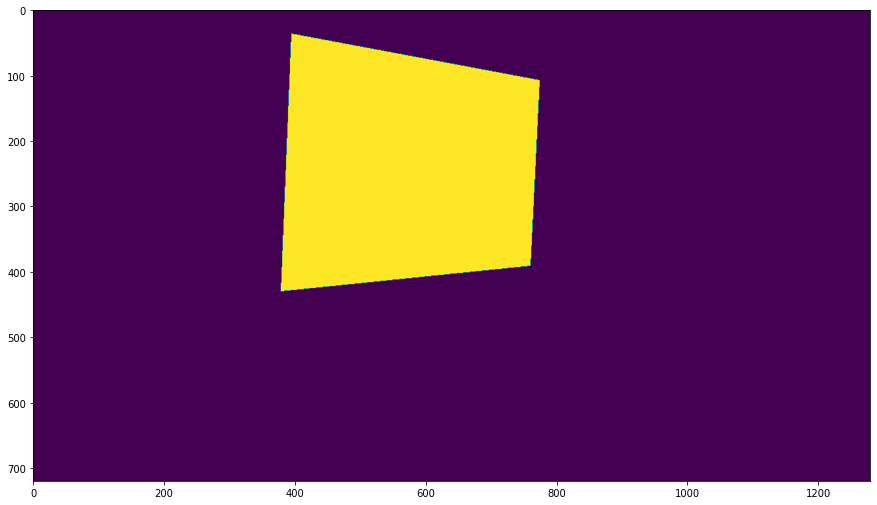

In [190]:
mask = np.zeros(color_image.shape[:2], dtype="uint8")

cv2.fillPoly(mask, np.int32([mask_points]), 1)
plt.figure(figsize=(15,25))
plt.imshow(mask)

In [191]:
normal_points

array([[437.,  91.],
       [420., 396.],
       [740., 238.]])

In [192]:
masked_depth = cv2.bitwise_and(depth_image,depth_image,mask=mask)

import math

deg_h = 69.4
deg_v = 42.5

px_h = masked_depth * math.tan(math.radians(deg_h/2)) / (depth_image.shape[1] / 2)
px_v = masked_depth * math.tan(math.radians(deg_v/2)) / (depth_image.shape[0] / 2)

sum_x = 0
x_coor = []
for i in range(3):
    coor = np.int64(normal_points[i])
    for j in range(coor[0]):
        sum_x += px_h[coor[1]][j]
    x_coor.append(sum_x)
    sum_x = 0

sum_y = 0
y_coor = []
for i in range(3):
    coor = np.int64(normal_points[i])
    for j in range(coor[1]):
        sum_y += px_v[j][coor[0]]
    y_coor.append(sum_y)
    sum_y = 0

In [193]:
A_xy = np.array([x_coor[0],y_coor[0]])
B_xy = np.array([x_coor[1],y_coor[1]])
C_xy = np.array([x_coor[2],y_coor[2]])

normal_points = np.int64(normal_points)

A = np.append(A_xy,depth_image[normal_points[0][1]][normal_points[0][0]])
B = np.append(B_xy,depth_image[normal_points[1][1]][normal_points[1][0]])
C = np.append(C_xy,depth_image[normal_points[2][1]][normal_points[2][0]])

AB = B - A
CB = B - C
normal = np.cross(AB,CB)
norm_unit = normal / np.linalg.norm(normal)

norm_unit

array([-0.60214413, -0.19642157,  0.77384819])

In [194]:
camera = np.array([0,0,-1])

dot_product = np.dot(camera, norm_unit)
angle = np.arccos(dot_product)

np.degrees(angle)

140.70072171213977

In [195]:
px_h /= math.cos(angle)
px_v /= math.cos(angle)

area = px_h * px_v
paper_area = np.sum(area)

error = np.abs(paper_area - 62370)/62370 * 100

print("Area of the paper is {:0.2f} mm^2.".format(paper_area))
print("True value is 62370 mm^2.")
print("Percent error is {:0.2f}%.".format(error))

Area of the paper is 81716.34 mm^2.
True value is 62370 mm^2.
Percent error is 31.02%.
